# Preparación y representación vectorial de documentos/textos en embeddings, indexación y almacenamiento en una base de datos vectorial

referencia:

[1] https://github.com/openai/openai-cookbook/blob/main/examples/vector_databases/pinecone/README.md

[2]https://github.com/pinecone-io/examples/blob/master/learn/generation/openai/gpt-4-langchain-docs.ipynb


[3] https://docs.pinecone.io/docs/quickstart


[4]https://github.com/Azure-Samples/Azure-OpenAI-Docs-Samples/blob/main/Samples/Tutorials/Embeddings/embedding_billsum.ipynb

Este notebook toma los ejemplos de la referencia 2 y 4 y los aplica al dataset de tweets de cambio climatico:

* Leer conjunto de datos y preprocesarlo.
* Limpiar el texto y/o documento y crear embeddings (representacion vectorial) con modelo seleccionado: openIA ada-002 
* Realizar una busqueda de texto a traves de una seleccion de vectores similares en el dataframe.
* Crear el indice y agregar los embeddings en el indice creado de la base de datos vectorial seleccionada: pinecone.


### Base de datos vectorial seleccionada pinecone

- **configuracion**: Instalar, Importar librerias y cargar variables de ambiente para conexion a base de datos vectorial pinecone y a modelo de embeddings openIA. [2][3][4]
- **leer dataset y crear embdedings**: leer el dataset, aumentar el texto y crear embeddings con modelo de OpenIA.
- **Base de datos vectorial: Pinecone**
    - Configurar y crear el cliente para conexion con VDB Pinecone. 
    - Crear indice
    - Cargar vectores y metadata en indice


In [ ]:
#pip install openai python-dotenv pinecone-client numpy pandas tiktoken

## Importar librerias

In [40]:

import os
import pandas as pd
import re
import numpy as np
import tiktoken
from openai import AzureOpenAI
from dotenv import load_dotenv
from tqdm.auto import tqdm
from time import sleep
from pinecone import Pinecone

## configurar variables de ambiente y rutas

In [41]:
load_dotenv()
OPENAI_ENDPOINT = os.environ["AZURE_OPENAI_ENDPOINT"]
OPENAI_API_KEY = os.environ["AZURE_OPENAI_API_KEY"] 
EMBEDDING_DEPLOYMENT = os.environ["AZURE_EMBEDDING_DEPLOYMENT"] 
OPENAI_API_VERSION =os.environ["OPENAI_API_VERSION"] 

api_key = os.environ.get('PINECONE_API_KEY') or 'PINECONE_API_KEY'
environment = os.environ.get('PINECONE_ENVIRONMENT') or 'PINECONE_ENVIRONMENT'
use_serverless = os.environ.get("USE_SERVERLESS", "False").lower() == "true"

In [42]:
src_path = os.getcwd()
data_path = '../data'
filename = 'climateTwitterData.csv'
out_data_path = data_path+'data/out/batch/'

## Leer dataset de entrada

In [43]:
df=pd.read_csv(os.path.join(src_path,data_path,filename))
df.head()

C:\Users\felip\AppData\Local\Temp\ipykernel_5024\788048299.py:1: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(os.path.join(src_path,data_path,filename))


,Unnamed: 0.1,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,hashtags,geo,urls,search_hashtags,location,sentiment1,sentiment2
0,0,0,1.211810e+18,7.590000e+17,"2020 is the year we #votethemout, the year we ...",15,https://twitter.com/Sphiamia/status/1211807074...,2019-12-31 00:31:35+00:00,Tue Dec 31 00:31:35 +0000 2019,46,NaN,#votethemout #climatestrike #rebelforlife,NaN,NaN,#climatestrike,"California, USA",negative,negative
1,1,1,1.210670e+18,2.219547e+07,Winter has not stopped this group of dedicated...,9,https://twitter.com/StephDujarric/status/12106...,2019-12-27 20:56:21+00:00,Fri Dec 27 20:56:21 +0000 2019,35,NaN,#climatefriday #climatestrike #ClimateAction,NaN,NaN,#climatestrike,"California, USA",positive,positive
2,2,2,1.210590e+18,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,545,https://twitter.com/AlexandriaV2005/status/121...,2019-12-27 15:50:22+00:00,Fri Dec 27 15:50:22 +0000 2019,3283,@UN @Fridays4future,#ClimateStrike,NaN,NaN,#climatestrike,"California, USA",positive,positive
3,3,3,1.210260e+18,1.339821e+09,"A year of resistance, as youth protests shape...",1,https://twitter.com/EnergyHouseVA/status/12102...,2019-12-26 17:53:26+00:00,Thu Dec 26 17:53:26 +0000 2019,2,NaN,#greta #gretathunberg #climatechange #fridaysf...,NaN,https://www.channelnewsasia.com/news/commentar...,#climatestrike,"California, USA",positive,positive
4,4,4,1.209640e+18,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,1,https://twitter.com/EnergyHouseVA/status/12096...,2019-12-25 00:56:37+00:00,Wed Dec 25 00:56:37 +0000 2019,4,NaN,#greta #gretathunberg #climatechange #fridaysf...,NaN,"http://www.energyhouse.us,http://www.pacenowfo...",#climatestrike,"California, USA",positive,positive


In [44]:
df['search_hashtags'].value_counts()

search_hashtags
#climatestrike       18355
#climatechange       16190
#climateaction        6378
#sustainability       5790
#climatecrisis        4982
#environment          4703
#greennewdeal         4589
#globalwarming        4152
#fridaysforfuture     3038
#actonclimate         1895
#savetheplanet        1434
#bushfires             899
Name: count, dtype: int64

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72405 entries, 0 to 72404
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0.1     72405 non-null  int64  
 1   Unnamed: 0       72405 non-null  int64  
 2   id               72405 non-null  float64
 3   author_id        72405 non-null  float64
 4   text             72405 non-null  object 
 5   retweets         72405 non-null  int64  
 6   permalink        72405 non-null  object 
 7   date             72405 non-null  object 
 8   formatted_date   72405 non-null  object 
 9   favorites        72405 non-null  int64  
 10  mentions         27554 non-null  object 
 11  hashtags         72402 non-null  object 
 12  geo              0 non-null      float64
 13  urls             33349 non-null  object 
 14  search_hashtags  72405 non-null  object 
 15  location         72405 non-null  object 
 16  sentiment1       30000 non-null  object 
 17  sentiment2  

## Preprocesar dataset para crear embeddings

### pre-pocesar dataframe

In [46]:
df_procesado = df[['text','date','hashtags','search_hashtags',	'location',	'sentiment1']]

df_procesado = df_procesado.dropna(thresh= 4 , axis=0 )

df_procesado = df_procesado.drop_duplicates()

df_procesado.head()

,text,date,hashtags,search_hashtags,location,sentiment1
0,"2020 is the year we #votethemout, the year we ...",2019-12-31 00:31:35+00:00,#votethemout #climatestrike #rebelforlife,#climatestrike,"California, USA",negative
1,Winter has not stopped this group of dedicated...,2019-12-27 20:56:21+00:00,#climatefriday #climatestrike #ClimateAction,#climatestrike,"California, USA",positive
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,2019-12-27 15:50:22+00:00,#ClimateStrike,#climatestrike,"California, USA",positive
3,"A year of resistance, as youth protests shape...",2019-12-26 17:53:26+00:00,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike,"California, USA",positive
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,2019-12-25 00:56:37+00:00,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike,"California, USA",positive


In [47]:
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61254 entries, 0 to 72404
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             61254 non-null  object
 1   date             61254 non-null  object
 2   hashtags         61252 non-null  object
 3   search_hashtags  61254 non-null  object
 4   location         61254 non-null  object
 5   sentiment1       24709 non-null  object
dtypes: object(6)
memory usage: 3.3+ MB


In [48]:
# Convertir la columna "date" a formato str aaaa-mm-dd sin la hora
df_procesado.loc[:,'date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

# Manejar NaN en la columna 'hashtags' y 'sentiment1'
df_procesado.loc[:,'hashtags'] = df_procesado['hashtags'].fillna('')

df_procesado.loc[:,'sentiment1'] = df_procesado['sentiment1'].fillna('')

# unir columnas
df_procesado.loc[:,'aumented_text'] = df_procesado['text'] + '. date: ' + df_procesado['date'] + '. location: ' + df_procesado['location'] + '. sentiment: ' + df_procesado['sentiment1']

#crear indice para los embeddigs del texto de cada fila
df_procesado = df_procesado.reset_index(names="id")

df_procesado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61254 entries, 0 to 61253
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               61254 non-null  int64 
 1   text             61254 non-null  object
 2   date             61254 non-null  object
 3   hashtags         61254 non-null  object
 4   search_hashtags  61254 non-null  object
 5   location         61254 non-null  object
 6   sentiment1       61254 non-null  object
 7   aumented_text    61254 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.7+ MB


### limpieza de texto columna aumentet_text

In [49]:
def limpiar_texto(texto:str):
    texto = texto.lower() 
    texto = re.sub(r'\s+',  ' ', texto).strip()
    texto = texto.replace("\n", "")
    texto = texto.strip()
    return texto

df_procesado['clean_text']= df_procesado["aumented_text"].apply(lambda x : limpiar_texto(x))

Segun la documentacion del modelo de embed text-embedding-ada-002 el numero de tokens no debe exceder 8192. Sino se debe dividir el texto. Para este dataset no es necesario, ningun texto supera ese numero.

In [50]:
tokenizer = tiktoken.get_encoding("cl100k_base")
# calcular el numero de tokest en el texto 
df_procesado['n_tokens_text'] = df_procesado["aumented_text"].apply(lambda x: len(tokenizer.encode(x)))
df_procesado['n_tokens_clean'] = df_procesado["clean_text"].apply(lambda x: len(tokenizer.encode(x)))


In [51]:
df_procesado[['n_tokens_text','n_tokens_clean']].describe()

,n_tokens_text,n_tokens_clean
count,61254.000000,61254.000000
mean,68.726173,68.453815
std,25.124593,24.939604
min,21.000000,21.000000
25%,50.000000,50.000000
50%,68.000000,68.000000
75%,85.000000,85.000000
max,455.000000,408.000000


In [52]:
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61254 entries, 0 to 61253
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               61254 non-null  int64 
 1   text             61254 non-null  object
 2   date             61254 non-null  object
 3   hashtags         61254 non-null  object
 4   search_hashtags  61254 non-null  object
 5   location         61254 non-null  object
 6   sentiment1       61254 non-null  object
 7   aumented_text    61254 non-null  object
 8   clean_text       61254 non-null  object
 9   n_tokens_text    61254 non-null  int64 
 10  n_tokens_clean   61254 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 5.1+ MB


In [53]:
def crear_metadata(row):
    metadata = {
        "search_hashtags": row["search_hashtags"],
        "date": row["date"],
        "location": row["location"],
        "hashtags": row["hashtags"],
        "sentiment1": row["sentiment1"],
        "texto": row["clean_text"]
    }
    return metadata
df_procesado['metadata'] = df_procesado.apply(lambda row: crear_metadata(row), axis=1)

In [54]:
df_final_procesado = df_procesado[['id','clean_text','metadata']].copy()

In [55]:
df_final_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61254 entries, 0 to 61253
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          61254 non-null  int64 
 1   clean_text  61254 non-null  object
 2   metadata    61254 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


##   Crear embeddings con modelo de embeddings pre-entrenado de OpenIA

### crear cliente para conexion con modelo de embedding de azure openIA

In [56]:
client = AzureOpenAI(
  api_key = OPENAI_API_KEY,  
  api_version = OPENAI_API_VERSION,
  azure_endpoint = OPENAI_ENDPOINT
)
def generar_embedding(texto:str, modelo:str=EMBEDDING_DEPLOYMENT)->list[float]:
    """Funcion para crear embedings a partir de un texto usando modelo model """
    return client.embeddings.create(input = [texto], model=modelo).data[0].embedding

def generar_embeddings_por_lote(textos:list, modelo:str=EMBEDDING_DEPLOYMENT)->list:
    """Funcion para crear embedings a partir de una lista de textos usando modelo model """
    return client.embeddings.create(input = textos, model=modelo).data
    

### Crear funcion para crear embeddings de textos en dataframe por lotes

In [57]:
def procesar_df_por_lotes(df:pd.DataFrame,tamaño_lote:int= 200, guardar:bool = True)->pd.DataFrame:
    """Funcion para procesar dataframe por lotes de n_lote """

    # Dividir el DataFrame en lotes y procesar cada lote
    lotes = []
    lote_inicial =0
    lote_actual = 0
    for i in tqdm(range(0, len(df), tamaño_lote)):
        # indice final del lote
        i_end = min(len(df), i+tamaño_lote)
        meta_batch = df[i:i_end]
        # lista ids
        ids_batch = [x['id'] for _,x in meta_batch.iterrows()]
        # lista de textos para embed
        textos = [x['clean_text'] for _,x in meta_batch.iterrows()]
        # lista metadatos
        # crear embeddings
        try:
            res = generar_embeddings_por_lote(textos, modelo=EMBEDDING_DEPLOYMENT)
        except Exception as e:
            done = False
            print(f"Reitentar solicitud, error {e}")
            while not done:
                sleep(5)
                try:
                    res = generar_embeddings_por_lote(textos, modelo=EMBEDDING_DEPLOYMENT)
                    done = True
                except:
                    print(f"Reitentar solicitud, error {e}")
                    pass
        embeds = [record.embedding for record in res]
        metadata_batch = meta_batch['metadata'].to_list()

        embeded_data = list(zip(ids_batch, textos ,embeds, metadata_batch))

        # Crear un DataFrame a partir de los datos combinados
        df_embeded = pd.DataFrame(embeded_data, columns=['id','text','embeddings','metadata'])

        lotes.append(df_embeded)
        lote_actual = lote_actual + 1
        if (lote_actual % 20 == 0) and guardar:
            
            # Guardar el archivo temporal cada 2000 ejecuciones
            file_name = f'climateTwitterEmbedData_{i_end}.csv'
            file_path = os.path.join(src_path, data_path, 'out', 'batch', file_name)
            lista_temp= lotes[lote_inicial:lote_actual]
            print(f"lote_actual->{lote_actual}")
            print(f"lote_inicial->{lote_inicial}")
            print(f"lista_temporal_guardada->{len(lista_temp)}")


            df_embeded_accum = pd.concat(lista_temp, ignore_index=True)
            df_embeded_accum.to_csv(file_path, sep=";",index=False)
            lote_inicial = lote_actual
            
  
    # Concatenar los resultados en un solo DataFrame
    df_out = pd.concat(lotes, ignore_index=True)
    return df_out

### Crear df con ids, vectores y metadata para cargar en base de datos vectorial

In [58]:
df_embeded = procesar_df_por_lotes(df_final_procesado,tamaño_lote= 200)

  6%|▌         | 19/307 [18:25<4:55:00, 61.46s/it]

lote_actual->20
lote_inicial->0
lista_temporal_guardada->20


 13%|█▎        | 39/307 [38:46<4:33:03, 61.13s/it]

lote_actual->40
lote_inicial->20
lista_temporal_guardada->20


 19%|█▉        | 59/307 [59:09<4:13:10, 61.25s/it]

lote_actual->60
lote_inicial->40
lista_temporal_guardada->20


 26%|██▌       | 79/307 [1:19:33<3:54:01, 61.59s/it]

lote_actual->80
lote_inicial->60
lista_temporal_guardada->20


 32%|███▏      | 99/307 [1:39:54<3:31:47, 61.10s/it]

lote_actual->100
lote_inicial->80
lista_temporal_guardada->20


 39%|███▉      | 119/307 [2:00:18<3:11:39, 61.17s/it]

lote_actual->120
lote_inicial->100
lista_temporal_guardada->20


 45%|████▌     | 139/307 [2:20:42<2:51:05, 61.11s/it]

lote_actual->140
lote_inicial->120
lista_temporal_guardada->20


 52%|█████▏    | 159/307 [2:41:04<2:30:30, 61.02s/it]

lote_actual->160
lote_inicial->140
lista_temporal_guardada->20


 58%|█████▊    | 179/307 [3:01:26<2:10:19, 61.09s/it]

lote_actual->180
lote_inicial->160
lista_temporal_guardada->20


 65%|██████▍   | 199/307 [3:21:48<1:49:44, 60.97s/it]

lote_actual->200
lote_inicial->180
lista_temporal_guardada->20


 70%|██████▉   | 214/307 [3:37:06<1:34:44, 61.13s/it]

Reitentar solicitud, error Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the Embeddings_Create Operation under Azure OpenAI API version 2023-05-15 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 52 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}


 71%|███████▏  | 219/307 [3:43:21<1:34:19, 64.32s/it]

lote_actual->220
lote_inicial->200
lista_temporal_guardada->20


 78%|███████▊  | 239/307 [4:03:56<1:09:12, 61.07s/it]

lote_actual->240
lote_inicial->220
lista_temporal_guardada->20


 84%|████████▍ | 259/307 [4:24:19<48:51, 61.06s/it]  

lote_actual->260
lote_inicial->240
lista_temporal_guardada->20


 91%|█████████ | 279/307 [4:44:42<28:32, 61.17s/it]

lote_actual->280
lote_inicial->260
lista_temporal_guardada->20


 97%|█████████▋| 299/307 [5:05:04<08:08, 61.05s/it]

lote_actual->300
lote_inicial->280
lista_temporal_guardada->20


100%|██████████| 307/307 [5:13:12<00:00, 61.21s/it]


In [59]:
df_embeded

,id,text,embeddings,metadata
0,0,"2020 is the year we #votethemout, the year we ...","[-0.0329987034201622, -0.04772832244634628, -0...","{'search_hashtags': '#climatestrike', 'date': ..."
1,1,winter has not stopped this group of dedicated...,"[-0.022893592715263367, -0.0438067689538002, -...","{'search_hashtags': '#climatestrike', 'date': ..."
2,2,week 55 of #climatestrike at the @un. next wee...,"[-0.02628657966852188, -0.038114212453365326, ...","{'search_hashtags': '#climatestrike', 'date': ..."
3,3,"a year of resistance, as youth protests shaped...","[-0.013956073671579361, -0.04684501141309738, ...","{'search_hashtags': '#climatestrike', 'date': ..."
4,4,happy holidays #greta #gretathunberg #climatec...,"[-0.023563934490084648, -0.03334088623523712, ...","{'search_hashtags': '#climatestrike', 'date': ..."
...,...,...,...,...
61249,72400,no more straws at lbm... only if you ask for i...,"[-0.03119616024196148, -0.022216686978936195, ...","{'search_hashtags': '#savetheplanet', 'date': ..."
61250,72401,my #trumps may not believe in #climatechange b...,"[-0.04546879976987839, -0.015453536063432693, ...","{'search_hashtags': '#savetheplanet', 'date': ..."
61251,72402,time is over. act now!!! #friday4future #clima...,"[-0.01593591459095478, -0.028650032356381416, ...","{'search_hashtags': '#savetheplanet', 'date': ..."
61252,72403,this is my first contribution on visualizing t...,"[-0.012159015983343124, -0.01347509678453207, ...","{'search_hashtags': '#savetheplanet', 'date': ..."


In [60]:
# Guardar en formato pkl
file_name = "climateTwitterEmbedData.pkl"
file_path = os.path.join(src_path, data_path, 'out', file_name)
df_embeded.to_pickle(file_path)

## Prueba de busqueda de documentos localmente, sin base de datos vectorial, sobre el dataframe

In [62]:
def similaridad_coseno(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def busqueda_documentos_dataframe(df: pd.DataFrame, user_query:str, top_n:int=4)->pd.DataFrame:
    """Funcion para buscar textos en dataframe"""
    embedding = generar_embedding(
        user_query,
        modelo="text-embedding-ada-002" 
    )
    df["similarities"] = df.embeddings.apply(lambda x: similaridad_coseno(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    display(res)
    return res


res = busqueda_documentos_dataframe(df_embeded, "why winter has not stopped in California in 2019-12", top_n=5)

,id,text,embeddings,metadata,similarities
7217,8392,it appears like winter has been cancelled for ...,"[-0.026881268247961998, -0.031875453889369965,...","{'search_hashtags': '#globalwarming', 'date': ...",0.848884
59614,70497,it appears like winter has been cancelled for ...,"[-0.027261709794402122, -0.029249263927340508,...","{'search_hashtags': '#globalwarming', 'date': ...",0.831479
1,1,winter has not stopped this group of dedicated...,"[-0.022893592715263367, -0.0438067689538002, -...","{'search_hashtags': '#climatestrike', 'date': ...",0.830322
37841,44929,winter is not coming #globalwarming . date: 20...,"[-0.017101731151342392, -0.023731127381324768,...","{'search_hashtags': '#globalwarming', 'date': ...",0.824444
1151,1151,@usatodayweather it not normally this warm out...,"[-0.0009998481255024672, -0.020653579384088516...","{'search_hashtags': '#climatestrike', 'date': ...",0.823834


## Cargar embeddings a base de datos vectorial pinecone

### Iniciar conexion con base de datos vectorial


#### seleccionar tipo de pod: Serverless or Pod-based
Decidir que pod usar, ver documentacion: https://docs.pinecone.io/guides/indexes/configure-pod-based-indexes#changing-pod-sizes

In [63]:
# initialize connection to pinecone (get API key at app.pc.io)
# configure client
pc = Pinecone(api_key=api_key)

In [64]:

from pinecone import ServerlessSpec, PodSpec
import time

if use_serverless:
    spec = ServerlessSpec(cloud='aws', region='us-west-2')
else:
    spec = PodSpec(environment=environment,pod_type="s1.x1")

### Crear un indice

crear un indice en  la vdb pinecone

In [65]:
index_name = 'climate-twitter-data'

if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)

# we create a new index
pc.create_index(
        index_name,
        dimension=1536,  # dimensionality of text-embedding-ada-002
        metric='cosine', #'dotproduct'
        spec=spec
    )

# wait for index to be initialized
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

In [66]:
# confirmar que fue creado el indice
pc.list_indexes()

{'indexes': [{'dimension': 1536,
              'host': 'climate-twitter-data-s4apt1d.svc.gcp-starter.pinecone.io',
              'metric': 'cosine',
              'name': 'climate-twitter-data',
              'spec': {'pod': {'environment': 'gcp-starter',
                               'pod_type': 'starter',
                               'pods': 1,
                               'replicas': 1,
                               'shards': 1}},
              'status': {'ready': True, 'state': 'Ready'}}]}

### conexion a indice de VDB creado previamente

In [67]:
index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [68]:
#preparar dataframe en formato para cargar en vdb
df_embeded.rename(columns={'embeddings':'values'}, inplace=True)

df_embeded['id'] = df_embeded['id'].astype(str)

### Cargar vectores al indice creado en base de datos vectorial

In [69]:
index.upsert_from_dataframe(df_embeded[['id','values','metadata']], batch_size=100)

sending upsert requests: 100%|██████████| 61254/61254 [16:52<00:00, 60.50it/s]


{'upserted_count': 61254}

In [70]:
index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.61254,
 'namespaces': {'': {'vector_count': 61254}},
 'total_vector_count': 61254}

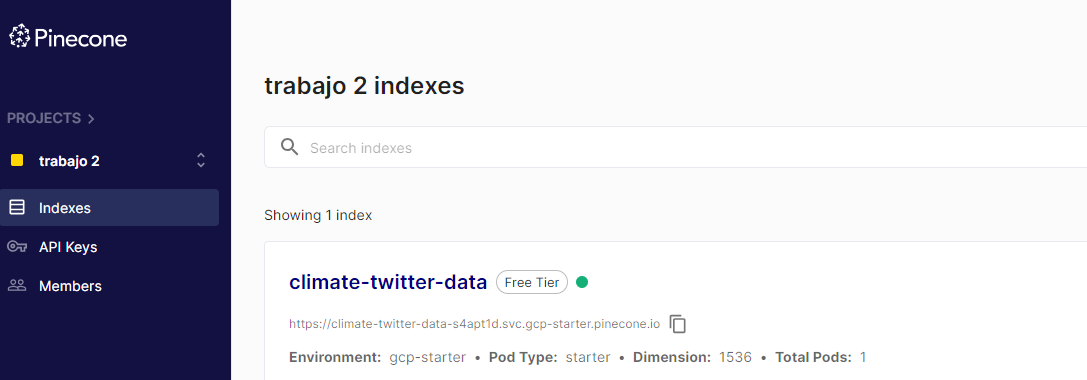